In [1]:
import torch
import pathlib
import cv2
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
%matplotlib inline

from passion.segmentation import prediction

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
models_folder_path = pathlib.Path('../../workflow/output/model')
superstructures_models_folder_path = models_folder_path / 'superst-segmentation'
rooftop_models_folder_path = models_folder_path / 'rooftop-segmentation'

# Sections model
model_rid_final = torch.load(str(superstructures_models_folder_path / 'superstructures-rid-20e.pth'), map_location=torch.device(device))

# Rooftop model
model_inria = torch.load(str(rooftop_models_folder_path / 'inria-aug-12e.pth'), map_location=torch.device(device))

In [4]:
rid_test_folder = pathlib.Path('/storage/internal/home/r-pueblas/projects/rooftop-segmentation-datasets/data/RID/output/masks_superstructures_reviewed/test')
rid_test_folder_image = rid_test_folder / 'image'
rid_test_folder_label = rid_test_folder / 'label'

In [5]:
def intersect_and_union(pred_label, label, num_classes, ignore_index):
    mask = (label != ignore_index)
    pred_label = pred_label[mask]
    label = label[mask]

    intersect = pred_label[pred_label == label]
    area_intersect, _ = np.histogram(
        intersect, bins=np.arange(num_classes + 1))
    area_pred_label, _ = np.histogram(
        pred_label, bins=np.arange(num_classes + 1))
    area_label, _ = np.histogram(label, bins=np.arange(num_classes + 1))
    area_union = area_pred_label + area_label - area_intersect

    return area_intersect, area_union, area_pred_label, area_label

In [6]:
def test_model_superstructures(model, test_folder, num_classes, background_class, ignore_index, output=True, num_samples=15):
    start = time.time()
    
    test_folder_image = test_folder / 'image'
    test_folder_label = test_folder / 'label'

    total_area_intersect = np.zeros((num_classes, ), dtype=float)
    total_area_union = np.zeros((num_classes, ), dtype=float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=float)
    total_area_label = np.zeros((num_classes, ), dtype=float)

    for i, filename in enumerate(test_folder_image.glob('*.png')):
        if i>num_samples: break
        image = cv2.imread(str(filename))
        label = cv2.imread(str(test_folder_label / filename.name))
        label = label[:,:,0]


        pred = prediction.segment_img(image, model, tile_size=512, stride=512, background_class=background_class)

        area_intersect, area_union, area_pred_label, area_label = \
                            intersect_and_union(pred, label, num_classes, ignore_index)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label

        if output:
            f, axarr = plt.subplots(1,3, figsize=(10, 10))
            axarr[0].imshow(image)
            axarr[1].imshow(label)
            axarr[2].imshow(pred)

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for ax in axarr:
                ax.axis('off')
            plt.show()

        iou = total_area_intersect / total_area_union

        if output: print(f'Processed image {filename.stem}, partial mean iou: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}, with background class: {np.mean(iou[~np.isnan(iou)])}')

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    iou = total_area_intersect / total_area_union

    end = time.time()
    elapsed_time = (end - start)

    if output:
        print('\n')
        print(f'Elapsed time: {elapsed_time} seconds')
        print(f'Final IoU per class: {iou}')
        print(f'Final mean IoU with background class: {np.mean(iou[~np.isnan(iou)])}')
        print(f'Final mean IoU without background class: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}')
    return iou, np.mean(iou[~np.isnan(iou)]), elapsed_time

def test_model_twolook(rooftop_model,
                       superstructures_model,
                       test_folder,
                       num_classes,
                       background_class_1,
                       background_class_2,
                       ignore_index,
                       output=True,
                       num_samples=15
                      ):
    start = time.time()
    
    test_folder_image = test_folder / 'image'
    test_folder_label = test_folder / 'label'

    total_area_intersect = np.zeros((num_classes, ), dtype=float)
    total_area_union = np.zeros((num_classes, ), dtype=float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=float)
    total_area_label = np.zeros((num_classes, ), dtype=float)

    for i, filename in enumerate(test_folder_image.glob('*.png')):
        if i>num_samples: break
        image = cv2.imread(str(filename))
        label = cv2.imread(str(test_folder_label / filename.name))
        label = label[:,:,0]
    
        roofs = prediction.segment_img(image, rooftop_model, tile_size=512, stride=512, background_class=background_class_1)
        filtered = np.ones(image.shape).astype(np.uint8)
        idx=(roofs!=0)
        filtered[idx] = image[idx]

        pred = prediction.segment_img(image, superstructures_model, tile_size=512, stride=512, background_class=background_class_2)
        pred = (pred * idx.astype('uint8'))
        area_intersect, area_union, area_pred_label, area_label = \
                            intersect_and_union(pred, label, num_classes, ignore_index)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label

        if output:
            f, axarr = plt.subplots(1,3, figsize=(10, 10))
            axarr[0].imshow(image)
            axarr[1].imshow(label)
            axarr[2].imshow(pred)

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for ax in axarr:
                ax.axis('off')
            plt.show()

        iou = total_area_intersect / total_area_union

        if output: print(f'Processed image {filename.stem}, partial mean iou: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}, with background class: {np.mean(iou[~np.isnan(iou)])}')

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    iou = total_area_intersect / total_area_union

    end = time.time()
    elapsed_time = (end - start)

    if output:
        print('\n')
        print(f'Elapsed time: {elapsed_time} seconds')
        print(f'Final IoU per class: {iou}')
        print(f'Final mean IoU with background class: {np.mean(iou[~np.isnan(iou)])}')
        print(f'Final mean IoU without background class: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}')

    return iou, np.mean(iou[~np.isnan(iou)]), elapsed_time

In [7]:
num_classes = 9
background_class = 0
ignore_index = -1

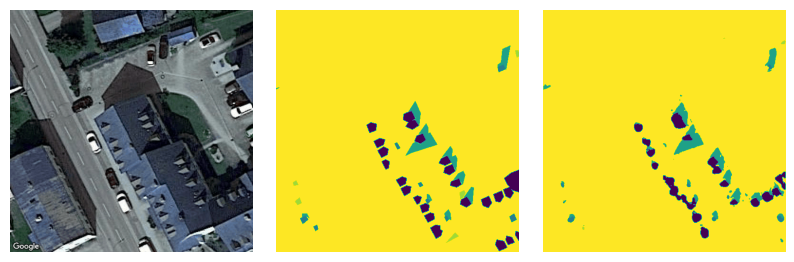

/tmp/ipykernel_1273181/3341227949.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Processed image 1277, partial mean iou: 0.3203089552808757, with background class: 0.42979923729195696


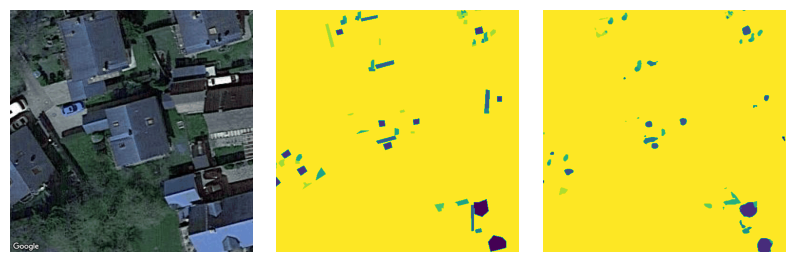

Processed image 1080, partial mean iou: 0.3448485795562324, with background class: 0.4152451723781803


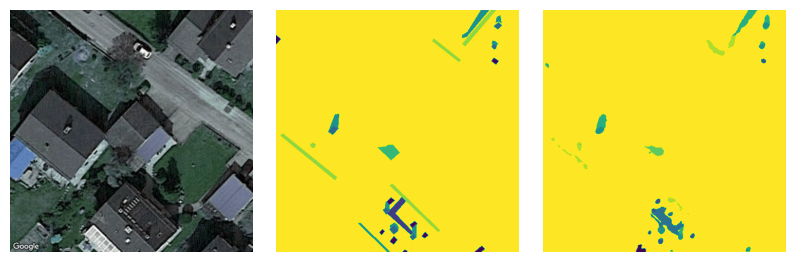

Processed image 785, partial mean iou: 0.3756396126195489, with background class: 0.4424725183793043


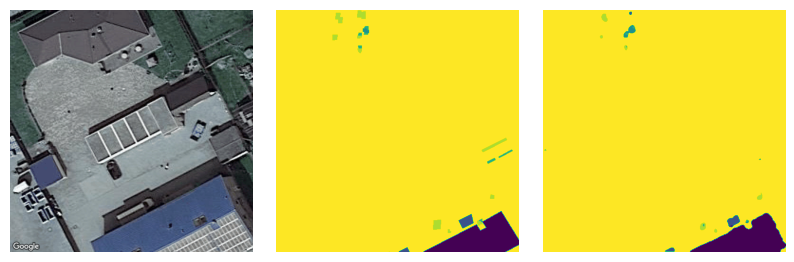

Processed image 1780, partial mean iou: 0.49319786159830925, with background class: 0.5473391165085042


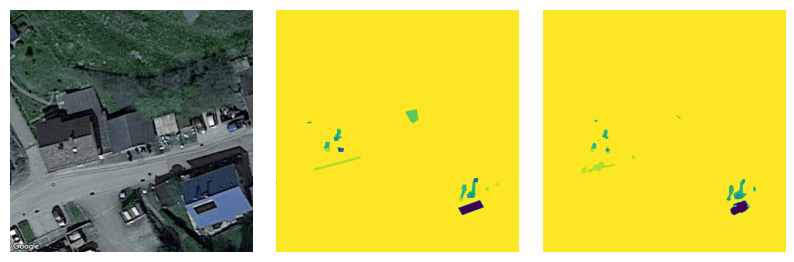

Processed image 1319, partial mean iou: 0.4646621282831061, with background class: 0.5222114360784826


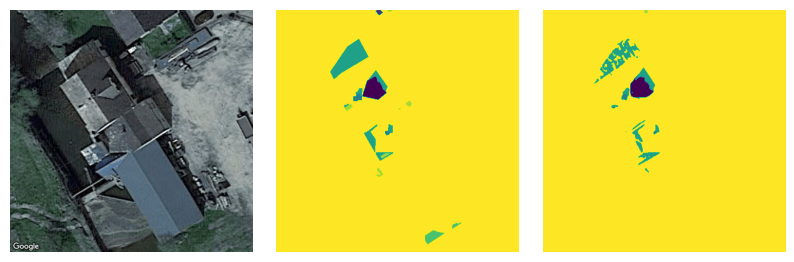

Processed image 1719, partial mean iou: 0.4538897705349096, with background class: 0.5127080112509989


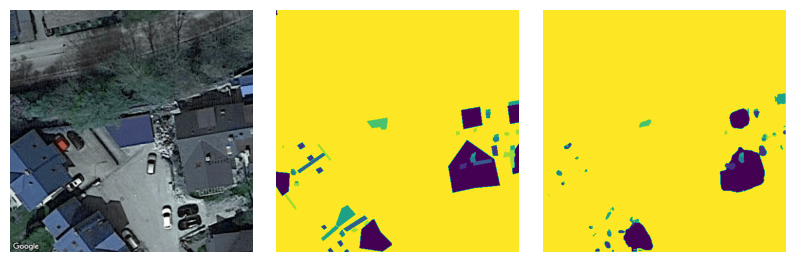

Processed image 1232, partial mean iou: 0.4349962043018125, with background class: 0.4954943713286179


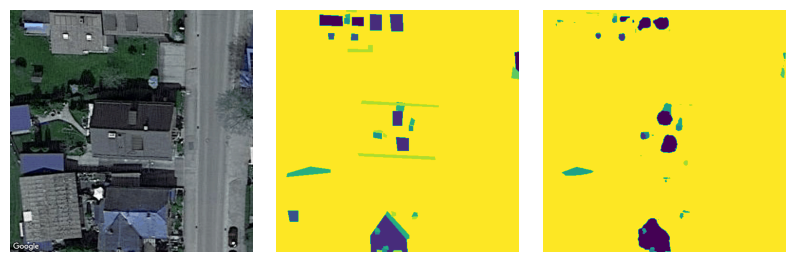

Processed image 1141, partial mean iou: 0.4139102757104961, with background class: 0.4765395993111292


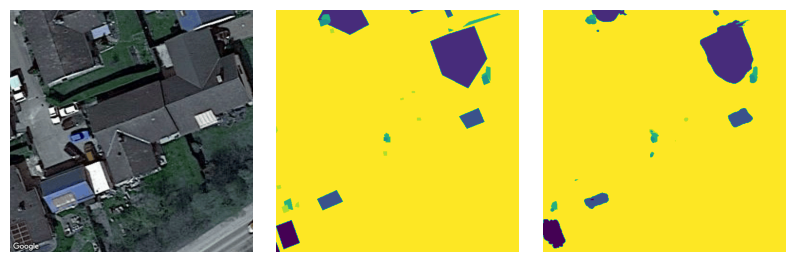

Processed image 1782, partial mean iou: 0.4322649786348044, with background class: 0.49279359256764327


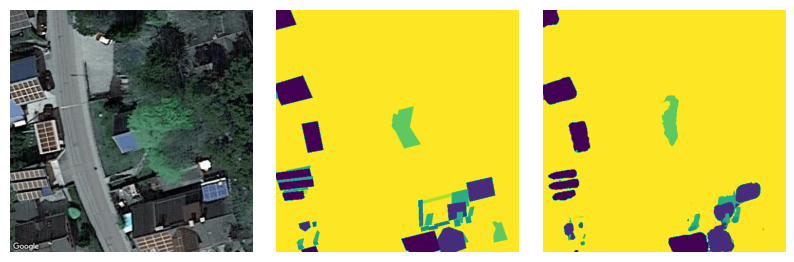

Processed image 1329, partial mean iou: 0.4428923620953301, with background class: 0.5020480883902122


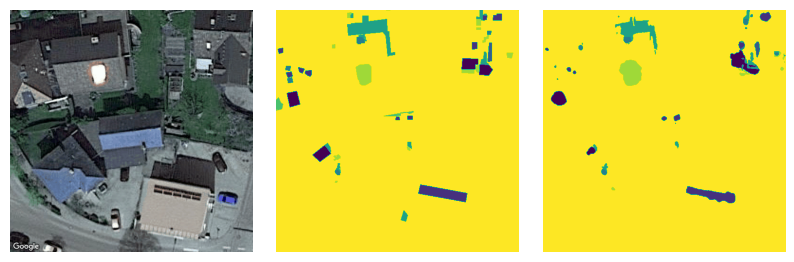

Processed image 1515, partial mean iou: 0.4508611841308796, with background class: 0.5091036799704465


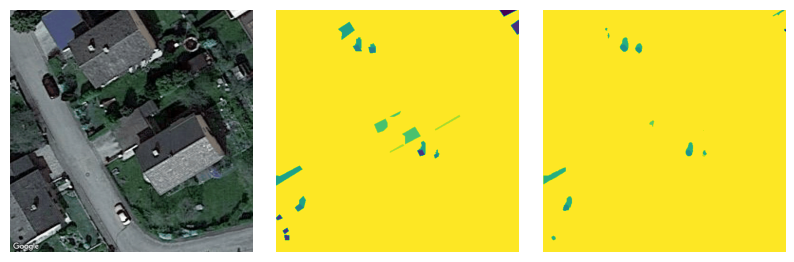

Processed image 52, partial mean iou: 0.44237015654536227, with background class: 0.5016615988965769


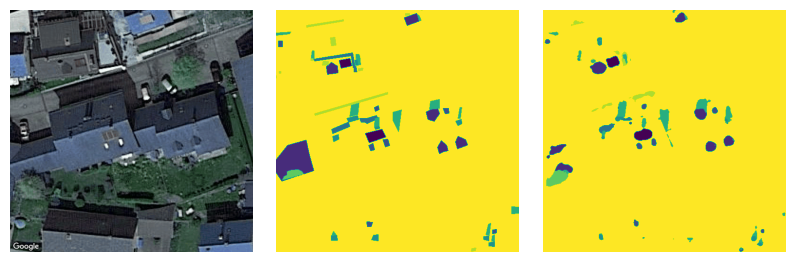

Processed image 1241, partial mean iou: 0.43618350573686243, with background class: 0.49601315196913287


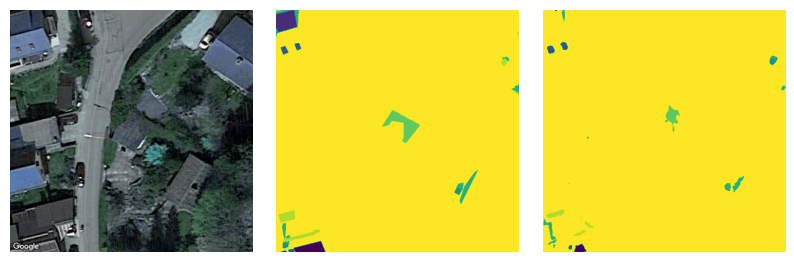

Processed image 1891, partial mean iou: 0.4270619472689259, with background class: 0.48789790012311823


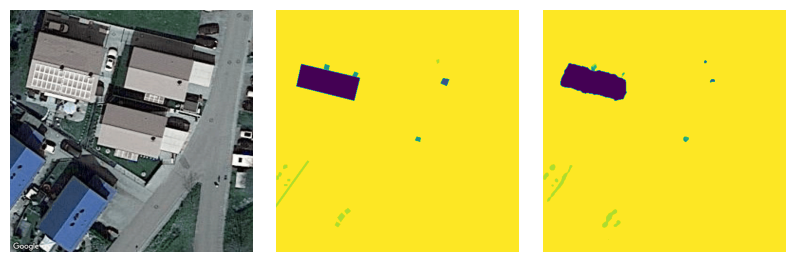

Processed image 302, partial mean iou: 0.4307778912717583, with background class: 0.49133244249515723


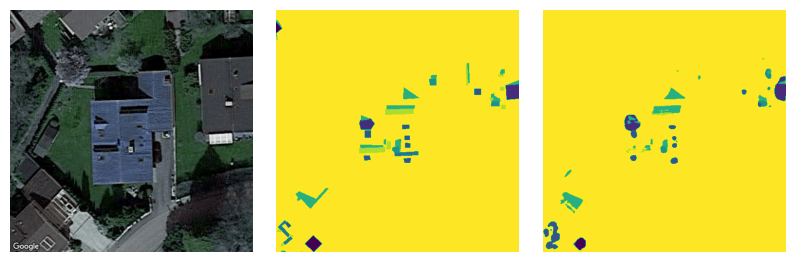

Processed image 475, partial mean iou: 0.42424534606668035, with background class: 0.4855506896485069


Elapsed time: 15.107376098632812 seconds
Final IoU per class: [0.77570538 0.59062434 0.49075796 0.19797388 0.40550807 0.48291426
 0.28507029 0.16540857 0.97599344]
Final mean IoU with background class: 0.4855506896485069
Final mean IoU without background class: 0.42424534606668035
Mean IoU: 0.4855506896485069
IoU per class: [0.77570538 0.59062434 0.49075796 0.19797388 0.40550807 0.48291426
 0.28507029 0.16540857 0.97599344]
Elapsed time: 15.107376098632812 seconds.


In [8]:
iou, mean_iou, elapsed_time = test_model_superstructures(model_rid_final,
                                                              rid_test_folder,
                                                              num_classes,
                                                              background_class,
                                                              ignore_index,
                                                              output=True)

print(f'Mean IoU: {mean_iou}')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')